In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import os


import cv2
import shutil
import numpy as np

from PIL import Image, ImageDraw
from ultralytics import YOLO

from utils.utils import list_file_r, copy_image_to_sub_dir, create_yolo_annotation_from_mask

In [4]:
# can install package here if needed
import sys
package_name = 'pillow' # enter package name here
!{sys.executable} -m pip install {package_name}

In [10]:
# dataset path
image_data_path = 'datasets/CF_simulation/images/'
sample_img = list_file_r(image_data_path)[-1]

mask_data_path = 'datasets/CF_simulation/mask/'
sample_mask = list_file_r(mask_data_path)[-1]

img, msk = cv2.imread(sample_img), cv2.imread(sample_mask)
msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
msk = cv2.bitwise_not(msk)
_, im = cv2.threshold(msk, 100, 255, type=cv2.THRESH_BINARY)

#black_border = np.zeros((100, 1000) ,dtype='uint8')
#im = np.concatenate((black_border, im), axis=0)
#print(im[-1])
Image.fromarray(im).show()
#contours, hierachy = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
# dataset path
image_data_path = 'datasets/CF_simulation/images/supp1'
sample_img = list_file_r(image_data_path)[-1]

mask_data_path = 'datasets/CF_simulation/mask/supp1'
sample_mask = list_file_r(mask_data_path)[-1]

img, msk = cv2.imread(sample_img), cv2.imread(sample_mask)
msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
msk = cv2.bitwise_not(msk)  # invert mask
_, im = cv2.threshold(msk, 100, 255, type=cv2.THRESH_BINARY)
height, width = im.shape
add_border_on_edge = True
if add_border_on_edge:
    border_height = 100
    black_border = np.zeros((border_height, 1000), dtype='uint8')
    #im = np.concatenate((black_border, im), axis=0)
contours, hierachy = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#Image.fromarray(img).show()

annotation_text = ''
bbox_text = ''
for contour in contours:
    # b-box
    bbox_text += '0 '
    x,y,w,h = cv2.boundingRect(contour)
    x,y = x+w/2, y+h/2
    x,y,w,h = x/width, y/height, w/width, h/height
    bbox_text += '{} {} {} {}\n' .format(x,y,w,h)
    # mask
    annotation_text += '0'
    for d in range(len(contour)):
        annotation_text += ' '
        #contour[d][0][1] -= border_height
        X, Y = contour[d][0]
        #Y = Y - border_height
        X, Y = X/width, Y/height
        annotation_text += '{} {}'.format(X, Y)
    annotation_text += '\n' # newline
print(annotation_text)
print(bbox_text)

cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
pil_image = Image.fromarray(img) 
pil_image.show() 
cv2.destroyAllWindows() 


In [5]:
add_border_on_edge = False
mask_data_path = 'datasets/CF_simulation/mask/background/augmented'
annotation_dst = 'datasets/CF_simulation/labels/background/augmented'
mask_pfs = list_file_r(mask_data_path)
create_yolo_annotation_from_mask(mask=mask_data_path,out=annotation_dst)

In [6]:
# randomly select images for train/validation set
if False:
    image_data_path = 'datasets/CF_simulation/images/supp2/augmented'
    annotation_path = 'datasets/CF_simulation/labels/supp2/augmented'
    if not os.path.exists(image_data_path):
        os.makedirs(image_data_path)
    if not os.path.exists(annotation_path):
        os.makedirs(annotation_path)
    image_pfs = list_file_r(path=image_data_path, extension=['.tif'])

    rng = np.random.default_rng(seed=12345)
    sample_size, validation_ratio = len(image_pfs), 0.05

    selected_image_pfs = rng.choice(image_pfs, size=sample_size, replace=False)
    validation_image_pfs = selected_image_pfs[:int(sample_size*validation_ratio)]
    training_image_pfs = selected_image_pfs[int(sample_size*validation_ratio):]


    copy_image_to_sub_dir(training_image_pfs, sub_dir='train') 
    copy_image_to_sub_dir(validation_image_pfs, sub_dir='val')
    

In [2]:
import torch
import torchvision

device = 'cuda'
boxes = torch.tensor([[0., 1., 2., 3.]]).to(device)
scores = torch.randn(1).to(device)
iou_thresholds = 0.5

print(torchvision.ops.nms(boxes, scores, iou_thresholds))

tensor([0], device='cuda:0')


In [ ]:
arguments={
    'epochs':50,
    'name':'augmented+_large_640_default',
    'imgsz':640,
    #'epochs':20,
}
model = YOLO('yolov8l-seg.yaml')
results = model.train(data='train_augmented.yaml', **arguments)

In [3]:
arguments={
    'epochs':100,
    'name':'augmented_orig+supps_nano_640_100epochs',
    'imgsz':640,
}
model = YOLO('yolov8n-seg.pt')
# train from previous checkpoint
#model = YOLO('runs/segment/augmented_orig+supps_large_640_50epochs/weights/best.pt')
results = model.train(data='train_augmented.yaml', **arguments)

New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.11.6 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=train_augmented.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=augmented_orig+supps_nano_640_100epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

train: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\augmented\train.cache... 20686 images, 1000 backgrounds, 0 corrupt: 100%|██████████| 20690/20690 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\augmented\val.cache... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]


Plotting labels to runs\segment\augmented_orig+supps_nano_640_100epochs\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.16G      1.338      2.694      1.466      1.424         35        640: 100%|██████████| 1294/1294 [05:40<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]


                   all       2000      11577       0.95      0.832      0.891      0.705      0.921        0.8      0.833       0.47

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       3.3G     0.9102      1.589     0.8125      1.115         24        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.39it/s]


                   all       2000      11577      0.968      0.859      0.921      0.746      0.948      0.838      0.883      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.38G     0.8862      1.492     0.7422        1.1         18        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.47it/s]


                   all       2000      11577      0.957       0.86       0.91      0.731      0.947       0.83      0.871      0.535

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.29G      0.851      1.423      0.683      1.082         18        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13<00:00,  4.78it/s]


                   all       2000      11577      0.976      0.877      0.928      0.779      0.972      0.866      0.915       0.63

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.28G     0.8008      1.331     0.6223      1.055         23        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]


                   all       2000      11577      0.977      0.891      0.941      0.808       0.97      0.884      0.929      0.644

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.37G     0.7626      1.267     0.5823      1.037         13        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.94it/s]


                   all       2000      11577       0.97      0.896      0.939      0.814      0.968      0.887      0.925      0.665

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.32G     0.7399       1.22     0.5584      1.024         23        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]


                   all       2000      11577      0.978      0.897      0.941      0.821      0.977      0.889      0.929      0.684

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.39G     0.7148      1.179     0.5329      1.014         21        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]


                   all       2000      11577      0.975      0.901      0.945      0.828      0.977      0.886      0.933      0.698

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.26G     0.7008      1.154     0.5201      1.006         14        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


                   all       2000      11577      0.977      0.904      0.948      0.842      0.975      0.898      0.938      0.712

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.3G     0.6811      1.123     0.5029      0.998         32        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


                   all       2000      11577       0.98      0.912       0.95      0.852      0.977      0.907      0.942      0.727

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100       3.3G     0.6714      1.104     0.4931     0.9921         37        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]


                   all       2000      11577      0.981       0.91      0.951      0.854      0.981      0.902      0.943      0.741

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.27G     0.6629      1.094     0.4861     0.9892         25        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]


                   all       2000      11577      0.984      0.912      0.954      0.859      0.984      0.908      0.948      0.748

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.31G     0.6561      1.081     0.4789     0.9866         25        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]


                   all       2000      11577      0.984      0.913       0.95      0.861      0.982      0.908      0.942      0.746

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.24G     0.6448      1.062     0.4704     0.9827         19        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


                   all       2000      11577      0.983       0.91      0.953      0.862      0.981      0.907      0.946      0.752

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.28G     0.6427      1.058     0.4667     0.9797         28        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]


                   all       2000      11577      0.985      0.917      0.954      0.865      0.986      0.909      0.946      0.751

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.25G     0.6334      1.035     0.4572     0.9747         30        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


                   all       2000      11577      0.984      0.914      0.953      0.868      0.986      0.909      0.948      0.757

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.29G     0.6314      1.035     0.4552     0.9737         25        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


                   all       2000      11577      0.986      0.916      0.957      0.873      0.985      0.911      0.949      0.764

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.31G     0.6252      1.024     0.4511     0.9713         31        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


                   all       2000      11577      0.984      0.919      0.957      0.875      0.984      0.914      0.949      0.764

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.28G     0.6216       1.02     0.4465     0.9688         30        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]


                   all       2000      11577      0.986      0.917      0.957      0.877      0.986      0.911       0.95      0.766

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.23G     0.6152      1.011     0.4424     0.9676         43        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]


                   all       2000      11577      0.983      0.921      0.956      0.875      0.985      0.914       0.95      0.772

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.29G     0.6115      1.005     0.4396     0.9666         22        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]


                   all       2000      11577      0.984      0.921      0.957      0.879      0.984      0.916      0.952       0.78

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.25G       0.61      1.006     0.4359     0.9641         16        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


                   all       2000      11577      0.984      0.921      0.956       0.88      0.985      0.914       0.95      0.774

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.31G      0.604     0.9908     0.4335     0.9628         25        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.14it/s]

                   all       2000      11577      0.982       0.92      0.956      0.882      0.981      0.917      0.952      0.782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.31G     0.5997     0.9834     0.4294     0.9598         15        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]


                   all       2000      11577      0.986      0.921      0.957      0.884      0.985      0.916      0.951      0.778

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.27G     0.5988     0.9809     0.4268     0.9591         24        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.987       0.92      0.957      0.885      0.985      0.916      0.951      0.778



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.27G     0.5953     0.9769     0.4246     0.9583         16        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.988      0.921      0.959      0.887      0.989      0.915      0.952      0.782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.26G       0.59     0.9698     0.4215     0.9571         27        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.14it/s]

                   all       2000      11577      0.987      0.922      0.958      0.888      0.987      0.916      0.952      0.782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.26G     0.5867     0.9684     0.4193     0.9559         19        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.988      0.922       0.96      0.889      0.988      0.917      0.952      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.28G     0.5862      0.961     0.4174     0.9549         24        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.987      0.923      0.959      0.889      0.988      0.916      0.952      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.38G     0.5833     0.9522     0.4141      0.953         20        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.989      0.921      0.959       0.89      0.988      0.916      0.952      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.34G     0.5802     0.9513     0.4122     0.9526         14        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.987      0.925       0.96       0.89      0.989      0.916      0.952      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.28G     0.5757     0.9402     0.4096     0.9518         10        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.989      0.923      0.961      0.892      0.988      0.917      0.953      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.23G     0.5763     0.9483     0.4097     0.9492         16        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]

                   all       2000      11577      0.987      0.925       0.96      0.892      0.988      0.916      0.953      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.24G     0.5752     0.9424     0.4083     0.9499         50        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]

                   all       2000      11577      0.987      0.925       0.96      0.893      0.987      0.919      0.954      0.792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.31G     0.5727     0.9368     0.4055      0.948         25        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       2000      11577      0.987      0.925       0.96      0.894      0.988      0.918      0.953      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.27G     0.5695     0.9332     0.4044     0.9471         23        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.14it/s]

                   all       2000      11577      0.988      0.926      0.961      0.894      0.988      0.919      0.954      0.793



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.25G     0.5678     0.9311      0.402     0.9468         35        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.14it/s]

                   all       2000      11577      0.988      0.927      0.961      0.895      0.987      0.921      0.954      0.795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.27G     0.5661     0.9332      0.401     0.9467         32        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.988      0.926      0.961      0.896      0.988       0.92      0.954      0.795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.31G     0.5641      0.925     0.3997     0.9446         10        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.15it/s]

                   all       2000      11577      0.989      0.924      0.961      0.896      0.989      0.919      0.954      0.794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.24G     0.5623     0.9255     0.3974     0.9439         19        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.988      0.925      0.961      0.897      0.988       0.92      0.955      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.24G      0.558     0.9168     0.3941     0.9433         31        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.988      0.925      0.961      0.898      0.989      0.921      0.957      0.798



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.23G     0.5562      0.908     0.3923     0.9421         22        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]

                   all       2000      11577      0.987      0.926      0.961      0.897      0.988      0.921      0.957      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.22G     0.5556     0.9116     0.3907     0.9423         24        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.987      0.925      0.962      0.898      0.988      0.921      0.957        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.38G     0.5517      0.906     0.3888       0.94         43        640: 100%|██████████| 1294/1294 [02:43<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]

                   all       2000      11577      0.987      0.926      0.962      0.898      0.987       0.92      0.957      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.28G     0.5505     0.9091     0.3901     0.9406         36        640: 100%|██████████| 1294/1294 [02:38<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.987      0.925      0.961      0.898       0.99      0.919      0.956      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.24G     0.5498     0.9086     0.3875     0.9394         21        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.15it/s]

                   all       2000      11577      0.988      0.924      0.961      0.899       0.99      0.917      0.957      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.25G     0.5465     0.8997     0.3845     0.9406         28        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.988      0.924      0.962      0.899      0.988      0.919      0.956      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.28G     0.5469     0.9009     0.3854     0.9401         22        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.989      0.923      0.962      0.899      0.989      0.919      0.957      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.28G     0.5463     0.8993     0.3846     0.9389         21        640: 100%|██████████| 1294/1294 [02:41<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]

                   all       2000      11577      0.988      0.924      0.962        0.9      0.989      0.918      0.957      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.27G      0.544     0.8934     0.3814     0.9366         24        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       2000      11577      0.988      0.924      0.961        0.9      0.989      0.919      0.957      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.29G     0.5441     0.8941     0.3815     0.9373         21        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.989      0.923      0.961        0.9      0.988      0.919      0.957      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.34G     0.5404     0.8899     0.3804     0.9358         29        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]

                   all       2000      11577      0.988      0.924      0.961        0.9      0.989      0.919      0.956      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.24G     0.5389     0.8874     0.3766     0.9356         20        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.988      0.924      0.961        0.9      0.989      0.919      0.956      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.26G     0.5365     0.8872     0.3771     0.9347         20        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.988      0.925      0.961        0.9      0.989      0.919      0.956      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.23G     0.5349     0.8799     0.3744     0.9344         29        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.986      0.926      0.961        0.9      0.989      0.919      0.957      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.26G     0.5318     0.8724     0.3725     0.9327         39        640: 100%|██████████| 1294/1294 [02:41<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.986      0.926      0.961        0.9      0.988      0.919      0.957      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.25G     0.5345     0.8756     0.3728      0.934         32        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.987      0.927      0.961        0.9      0.988       0.92      0.957      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.27G     0.5306     0.8745     0.3728     0.9327         44        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.987      0.927      0.961        0.9      0.987      0.921      0.957      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.22G      0.529     0.8713     0.3714     0.9331         30        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       2000      11577      0.986      0.927      0.962        0.9      0.987      0.921      0.957      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.3G     0.5274     0.8657     0.3686     0.9309         21        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       2000      11577      0.986      0.928      0.962      0.901      0.987      0.921      0.957      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.28G     0.5255     0.8611     0.3672     0.9308         14        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.986      0.927      0.962      0.901      0.987      0.921      0.957      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.27G     0.5257     0.8648     0.3672     0.9309         16        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.986      0.927      0.962      0.901      0.987      0.921      0.957      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.29G      0.522       0.86     0.3646     0.9292         30        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.986      0.927      0.962      0.901      0.987       0.92      0.956      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.3G     0.5215      0.856     0.3631     0.9287         25        640: 100%|██████████| 1294/1294 [02:43<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.986      0.928      0.962      0.901      0.988      0.919      0.957      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.23G      0.521     0.8559     0.3638     0.9293         32        640: 100%|██████████| 1294/1294 [02:49<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.986      0.928      0.962      0.901      0.988      0.919      0.957      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.27G     0.5162     0.8493     0.3603     0.9278         30        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.986      0.928      0.962      0.901      0.988      0.919      0.957      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.27G     0.5159     0.8476     0.3595     0.9279         24        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.985      0.928      0.962      0.901      0.989      0.918      0.956      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.35G     0.5148     0.8474     0.3586     0.9264         34        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]

                   all       2000      11577      0.985      0.928      0.962      0.901       0.99      0.918      0.957      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.37G     0.5153     0.8522     0.3599     0.9267         12        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.985      0.928      0.962      0.901       0.99      0.918      0.956      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.23G     0.5119     0.8435     0.3563     0.9253         29        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.986      0.928      0.962      0.902      0.989      0.918      0.957      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.28G     0.5096      0.842     0.3549     0.9263         21        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.08it/s]

                   all       2000      11577      0.986      0.928      0.962      0.902      0.989      0.918      0.957      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.33G     0.5077     0.8364     0.3526     0.9242         55        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.986      0.928      0.962      0.903      0.989      0.918      0.957      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.26G     0.5087     0.8387     0.3524      0.924         26        640: 100%|██████████| 1294/1294 [02:41<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.985      0.928      0.962      0.903      0.989      0.919      0.957      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.31G     0.5064     0.8383     0.3517     0.9245         19        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]

                   all       2000      11577      0.986      0.928      0.962      0.903      0.988      0.919      0.957      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.21G     0.5049     0.8308     0.3496     0.9217         30        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       2000      11577      0.986      0.928      0.962      0.903      0.987      0.921      0.957      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.29G     0.5042     0.8311     0.3495     0.9224         32        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.986      0.928      0.962      0.903      0.988       0.92      0.957      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.29G     0.5031     0.8329     0.3481      0.922         25        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]

                   all       2000      11577      0.987      0.928      0.962      0.903      0.988      0.921      0.956      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.2G     0.5004     0.8253      0.346     0.9219         26        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.986      0.928      0.962      0.903      0.989       0.92      0.957      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.22G     0.4978     0.8241      0.344     0.9212         17        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]

                   all       2000      11577      0.987      0.928      0.962      0.903      0.989       0.92      0.957      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.35G      0.497     0.8232     0.3442     0.9207         23        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       2000      11577      0.987      0.928      0.962      0.903      0.988       0.92      0.956      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.29G     0.4956     0.8155     0.3424     0.9208         23        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]

                   all       2000      11577      0.986      0.928      0.962      0.903      0.989      0.919      0.956      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.25G      0.495     0.8221     0.3426     0.9197         13        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.987      0.928      0.962      0.903      0.988       0.92      0.956      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.21G     0.4945      0.817     0.3424     0.9195         52        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]

                   all       2000      11577      0.987      0.927      0.962      0.903      0.988       0.92      0.956      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.2G      0.491     0.8101     0.3398     0.9188         22        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.987      0.927      0.962      0.903      0.988       0.92      0.956      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.23G      0.489     0.8089     0.3376     0.9181         25        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.987      0.927      0.962      0.903      0.988       0.92      0.956      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.33G      0.489     0.8067     0.3368     0.9174         18        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       2000      11577      0.987      0.927      0.962      0.903      0.988       0.92      0.957      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.25G      0.483     0.7993     0.3334     0.9159         14        640: 100%|██████████| 1294/1294 [02:40<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]

                   all       2000      11577      0.987      0.927      0.962      0.904      0.987      0.921      0.956      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.27G     0.4846     0.8005     0.3339     0.9165         30        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

                   all       2000      11577      0.987      0.927      0.962      0.904      0.989       0.92      0.956      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.24G     0.4826     0.8001     0.3325     0.9155         49        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.988      0.928      0.962      0.904      0.987      0.921      0.956       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.36G     0.4804     0.7973     0.3311     0.9143         27        640: 100%|██████████| 1294/1294 [02:39<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]

                   all       2000      11577      0.988      0.927      0.962      0.904      0.988      0.921      0.956       0.81


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


In [152]:
# validation
validation_results = model.val(data='train_augmented.yaml',
                               #imgsz=640,
                               #batch=16,
                               conf=0.8,
                               iou=0.9,
                               )

Ultralytics YOLOv8.1.0 🚀 Python-3.11.6 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)


val: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\augmented\val.cache... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:34<00:00,  3.62it/s]


                   all       2000      11577      0.996      0.913      0.956       0.94      0.995      0.912      0.956      0.879
Speed: 0.2ms preprocess, 11.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\segment\val


In [ ]:
validation_results.box

In [2]:
model = YOLO('runs/segment/augmented_orig+supps_large_640_100epochs/weights/best.pt')

In [3]:
#model = YOLO('yolov8l-seg.pt')
model = YOLO('runs/segment/augmented_orig+supps_nano_640_100epochs/weights/best.pt')
inference_results = model(source='datasets/CF_simulation/real_image/test_gs/', save=True, project='real_image_test' ,name='real_image_test', conf=0.70)


image 1/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\0006.tif: 512x640 3 ink traces, 316.0ms
image 2/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif: 640x640 8 ink traces, 6.0ms
image 3/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\1.tif: 640x640 6 ink traces, 6.0ms
image 4/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\2.tif: 640x640 4 ink traces, 6.0ms
image 5/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\2400.tif: 512x640 (no detections), 7.0ms
image 6/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\3.tif: 640x640 6 ink traces, 7.0ms
image 7/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\4.tif: 640x640 8 ink traces, 6.0ms
image 8/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\hdt5_0010.tif: 512x640 5 ink traces, 8.0ms
image 9/22 d:\xie\Vision\mcp_yolo\data


image 1/1 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\images\augmented\val\01_line_Radius4_3_Density2000_1000_Width90_Reflection_1.tif: 640x640 5 ink traces, 55.0ms
Speed: 3.0ms preprocess, 55.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
326.27027900031106
532.8484745851124
510.4845104830086
510.51941606445365
533.4151240840166


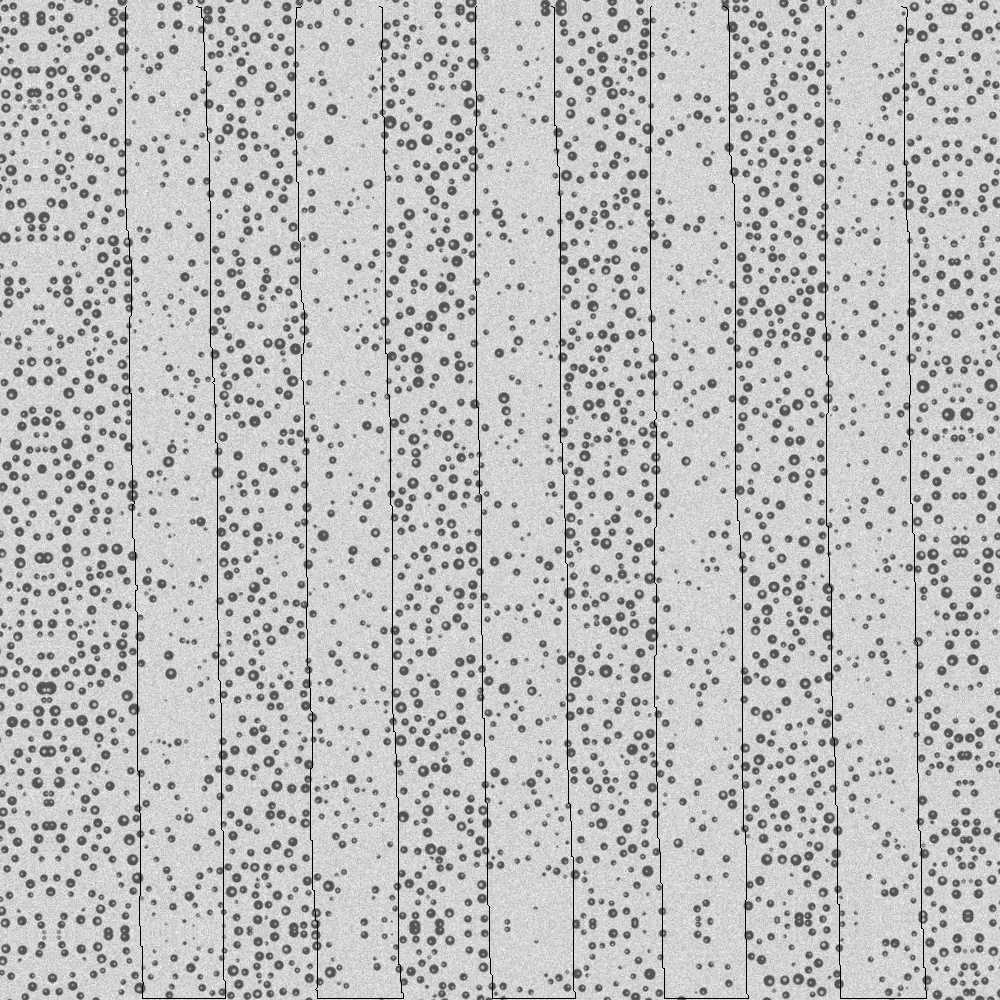

In [51]:
from utils.computation import draw_kernels
model = YOLO('runs/segment/augmented_orig+supps_large_640_100epochs/weights/best.pt')
img_path = 'datasets/CF_simulation/images/augmented/val/01_line_Radius4_3_Density2000_1000_Width90_Reflection_1.tif'
#img_path = 'datasets/CF_simulation/images/augmented/val/01_line_Radius4_2_Density1500_1000_Width50_Reflection_1.tif'

#inference_results = model(source='datasets/CF_simulation/images/val2/', save=True, project='validation_test', conf=0.70)
inference_results = model(source=img_path, save=False, project='validation_test', conf=0.70)
draw_kernels(inference_results, img_path)

In [46]:
Image.open(inference_results[0].path).size
filename =os.path.splitext(os.path.split(inference_results[1].path)[-1])[0]
#print((filename[39:42]))
from utils.computation import draw_kernels
draw_kernels(inference_results[16], 'D:/xie/Vision/mcp_yolo/validation_test/predict/05_sin_Radius5_3_Density1500_2000_Width60_Reflection_1_Curve1to7.tif')

(2, 28)
Elapsed time: 1.00017e-03
20.376413794374482
(2, 44)
Elapsed time: 0.00000e+00
14.546851061887951
(2, 29)
Elapsed time: 9.99451e-04
42.58093342966989
(2, 43)
Elapsed time: 0.00000e+00
38.66231381559961
(2, 28)
Elapsed time: 0.00000e+00
33.12822906692509
(2, 26)
Elapsed time: 0.00000e+00
22.96969935758081


In [146]:
import matplotlib.pyplot as plt
import time
#img = cv2.imread('datasets/CF_simulation/real_image/test/hdt5_0010.tif')
#img = Image.open('real_image_test/real_image_test/hdt5_1482.tif') 
img = Image.open('real_image_test/real_image_test7/01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif') 
img = Image.open('datasets/CF_simulation/real_image/test_gs/0006.tif')
draw = ImageDraw.Draw(img) 
w, h = img.size

from utils.computation import calculate_widths, get_image_widths_by_path_names
predicted_widths = calculate_widths(inference_results=inference_results)
true_widths = get_image_widths_by_path_names(inference_results=inference_results)
print(predicted_widths.shape, true_widths.shape)
#filename =os.path.splitext(os.path.split(inference_results[1].path)[-1])[0]
#print(int(filename[40:42]))
#print(filename[40:].find('_'))
#print([inference_results[i].path for i in range(len(inference_results))])
#plt.imshow(img)
#plt.show()

(622, 1) (622, 1)


In [ ]:
print(predicted_widths[:10], true_widths[:10])

In [151]:
# metrics 
errors = abs(predicted_widths - true_widths)/predicted_widths
np.quantile(errors, (0.1, 0.99))
errors.mean()

0.07550429134089048

(array([        201,         159,         123,          77,          39,          12,           4,           3,           3,           1]),
 array([ 0.00041019,    0.038447,    0.076484,     0.11452,     0.15256,     0.19059,     0.22863,     0.26667,     0.30471,     0.34274,     0.38078]),
 <BarContainer object of 10 artists>)

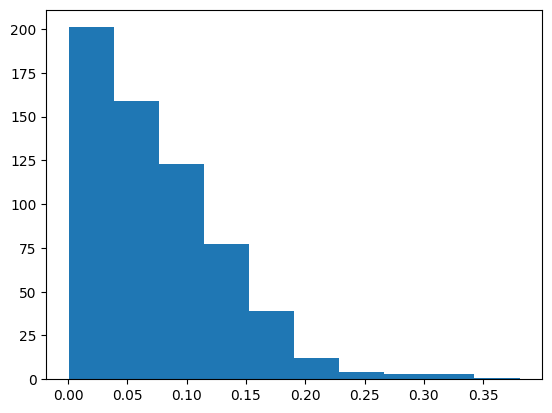

In [162]:
plt.hist(errors)

In [11]:
img = Image.open('real_image_test/real_image_test7/01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif')
mask = Image.new("RGB", img.size, "black")  


for coos in inference_results[0].masks.xy:
    polygons = ImageDraw.Draw(mask)
    polygons.polygon(coos, fill='white')
    # calculate the individual width
    temp_mask = Image.new("RGB", img.size, "black")
    temp = ImageDraw.Draw(temp_mask)  
    temp.polygon(coos, fill='white')
    temp_mask = temp_mask.convert('1')
    #temp_mask.show()
    temp_mask = np.array(temp_mask)
    
    scanned_heights=np.array([])
    for col in temp_mask.T:
        col_sum = col.sum()
        if col_sum:
            scanned_heights = np.append(scanned_heights,col.sum())
    #print("{:.6f}".format(np.quantile(scanned_heights, 0.5, method='median_unbiased')/2**.5/temp_mask.shape[-1]))
    #print(scanned_heights.max()/2**.5)
#mask.show()
mask = mask.convert('1')
#mask.show()
mask = np.array(mask)
scanned_heights=np.array([])
for col in mask.T:
    col_sum = col.sum()
    if col_sum:
        scanned_heights = np.append(scanned_heights,col.sum())
print("{:.6f}".format(np.quantile(scanned_heights, 0.5, method='median_unbiased')/2**.5/temp_mask.shape[-1]))
mask_matrix = np.array(mask)

0.106066


In [ ]:
# validate model
model = YOLO('runs/segment/largedata_20epochs_480p_nano/weights/best.pt')
model.val(data='val.yaml', task='detect')

In [ ]:
import PIL.ImageOps as ImageOps
#test_result = model('datasets/CF_simulation/images/IMG10_sin_Radius7_4_Density1500_1000_Width50_Reflection_0_Curve1to20.tif')
#print(test_result)
#print(test_result[0].boxes)
model = YOLO('runs/segment/train/weights/best.pt')
test_img_path = 'datasets/CF_simulation/images/IMG10_sin_Radius7_4_Density1500_1000_Width50_Reflection_0_Curve1to20.tif'
test_result = model.predict(test_img_path, show=True, boxes=False)
#res_plotted = test_result[0].plot()
#print(test_result[0].boxes)
#cv2.imshow("result", res_plotted)
mask_seg = test_result[0].masks.data
print(mask_seg.data.shape)
#img = Image.open(test_img_path)
#mask = Image.fromarray(np.uint8(255*mask))
#seg_img = Image.fromarray(np.uint8(mask_seg.data.numpy()[0]))
#seg_img.show()
#img1 = img.paste(seg_img, (0, 0), seg_img)
#img = Image.fromarray(res_plotted)
#img1.show()
import torchvision.transforms as T
im = np.array(Image.new('RGB', (640, 640), (0,0,0)))
for seg in mask_seg:
    current = T.ToPILImage()(seg).convert('RGB')
    #current = ImageOps.invert(current)
    current = np.array(current)
    print(current)
    im += current
    #im.paste(current)
im = Image.fromarray(im)
#im = ImageOps.invert(im)
im.show()

In [80]:
import torch
torch.cuda.empty_cache()

In [11]:
import os
dir_path = 'D:\\xie\\simulationdroplet\\dataset\\supp3\\mask'
#dir_path = 'D:\\xie\\Vision\\mcp_yolo\\datasets\\CF_simulation\\images\\supp3'
#dir_path = 'dataset/CF_simulation/images/supp1'
for filename in os.listdir(dir_path):
    #break
    #os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, filename[4:]))
    continue
    if filename.find('Width20') != -1:
        #continue
        os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, 'supp1_'+filename))
        #os.remove(os.path.join(dir_path, filename))
#print(l)